In [11]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
from cloud_colocations.products import gpm_1c_r, gpm_2a_gprofgmi, gpm_2b_cmb

In [43]:
t = datetime(2014, 8, 26, 10, 30, 25)
f = gpm_2a_gprofgmi.get_file_by_date(t)
f = gpm_2a_gprofgmi.download_file(f)
print(f)

https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L2/GPM_2AGPROFGPMGMI.05/2014/238/2A.GPM.GMI.GPROF2017v1.20140826-S102609-E115842.002797.V05A.HDF5
<Response [200]>
/tmp/tmpgq0bivab/2A.GPM.GMI.GPROF2017v1.20140826-S102609-E115842.002797.V05A.HDF5


## Input data

Input data for the GPM retrievals is taken from the 1C-r product which includes
all brightness temperatures remapped to common footprints.

In [44]:
f = gpm_1c_r.get_file_by_date(t)
f = gpm_1c_r.download_file(f)
f = h5py.File(f, "r")
lats = f["S1"]["Latitude"]
lons = f["S1"]["Longitude"]
i_start = lons.shape[0] // 4 - 100
i_end = lons.shape[0] // 4 + 100

bts_1 = f["S1"]["Tc"][i_start : i_end, :, :]
bts_2 = f["S2"]["Tc"][i_start : i_end, :, :]

https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L1C/GPM_1CGPMGMI_R.05/2014/238/1C-R.GPM.GMI.XCAL2016-C.20140826-S102609-E115842.002797.V05A.HDF5
<Response [200]>


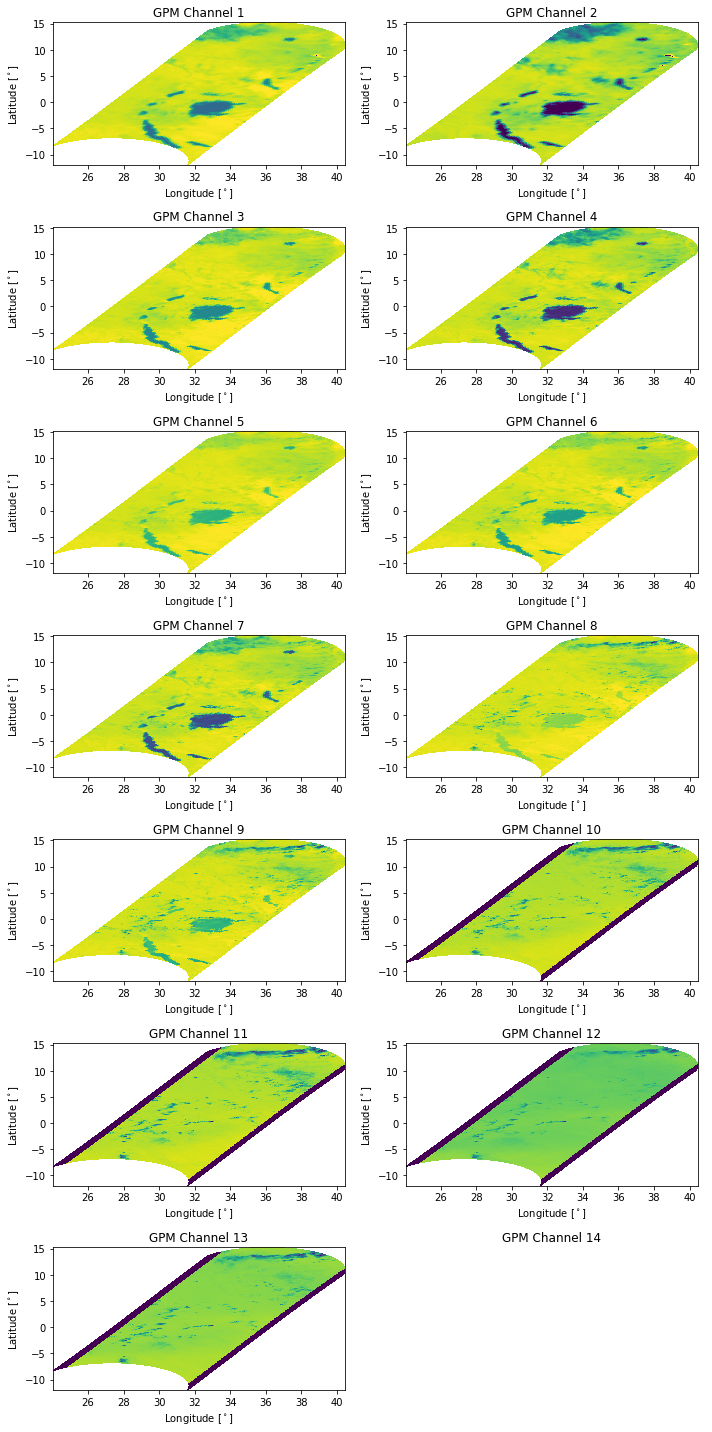

In [54]:
from matplotlib.colors import Normalize

x = lons[i_start : i_end, :]
y = lats[i_start : i_end, :]
f, axs = plt.subplots(7, 2, figsize = (10, 20))
norm = Normalize(100, 300)
axs = axs.ravel()
for i in range(14):
        
    ax = axs[i]
    ax.set_ylabel("Latitude [$^\circ$]")
    ax.set_xlabel("Longitude [$^\circ$]")
    ax.set_title("GPM Channel {}".format(i + 1))
        
    if i < 9:
        ax.pcolormesh(x, y, bts_1[:, :, i], norm = norm)
        
    elif i < 13:
        axs[i].pcolormesh(x, y, bts_2[:, :, i - 9], norm = norm)
    else:
        axs[i].set_axis_off()
plt.tight_layout()

## Auxiliary data

Auxiliary data is taken from the GPM 2A GPROF-GMI product.

In [68]:
f = gpm_2a_gprofgmi.get_file_by_date(t)
f = gpm_2a_gprofgmi.download_file(f)
f = h5py.File(f, "r")
f["S1"].keys()

<KeysViewHDF5 ['ScanTime', 'SCstatus', 'Latitude', 'Longitude', 'pixelStatus', 'qualityFlag', 'L1CqualityFlag', 'surfaceTypeIndex', 'totalColumnWaterVaporIndex', 'CAPE', 'temp2mIndex', 'sunGlintAngle', 'probabilityOfPrecip', 'spare2', 'surfacePrecipitation', 'frozenPrecipitation', 'convectivePrecipitation', 'rainWaterPath', 'cloudWaterPath', 'iceWaterPath', 'mostLikelyPrecipitation', 'precip1stTertial', 'precip2ndTertial', 'profileTemp2mIndex', 'profileNumber', 'profileScale']>

In [76]:
lat = f["S1"]['Latitude']
lon = f["S1"]['Longitude']
st = f["S1"]['surfaceTypeIndex'][:]
cw = f["S1"]['totalColumnWaterVaporIndex'][:]

## Ground truth

Ground truth is taken from the 2B combined product.

In [82]:
f = gpm_2b_cmb.get_file_by_date(t)
f = gpm_2b_cmb.download_file(f)
f = h5py.File(f, "r")
f["MS"].keys()

<KeysViewHDF5 ['ScanTime', 'scanStatus', 'navigation', 'Input', 'aPriori', 'FLG', 'Latitude', 'Longitude', 'surfaceAirPressure', 'surfaceAirTemperature', 'surfaceVaporDensity', 'skinTemperature', 'envParamNode', 'airPressure', 'airTemperature', 'vaporDensity', 'cloudLiqWaterCont', 'cloudIceWaterCont', 'phaseBinNodes', 'PSDparamLowNode', 'precipTotPSDparamLow', 'precipTotPSDparamHigh', 'precipTotWaterCont', 'precipTotWaterContSigma', 'precipTotRate', 'precipTotRateSigma', 'liqMassFracTrans', 'liqRateFracTrans', 'surfPrecipTotRate', 'surfPrecipTotRateSigma', 'surfLiqRateFrac', 'tenMeterWindSpeed', 'surfEmissivity', 'simulatedBrightTemp', 'nubfPIAfactor', 'multiScatMaxContrib', 'surfEmissSigma', 'tenMeterWindSigma', 'skinTempSigma', 'columnVaporSigma', 'columnCloudLiqSigma', 'errorOfDataFit', 'pia', 'correctedReflectFactor']>